In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
import numpy as np
import pandas as pd
import random as rd
data = pd.read_csv("drive/My Drive/clean_tweet.csv",index_col=0)
data.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,tweet_text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [86]:
data[data.isnull().any(axis=1)].head(20)


,tweet_text,target
208,NaN,0
249,NaN,0
282,NaN,0
398,NaN,0
430,NaN,0
1011,NaN,0
1014,NaN,0
1231,NaN,0
1421,NaN,0
1486,NaN,0


In [87]:
data.dropna(inplace=True) #NAN values are coming from just @username, delete them 
data.reset_index(drop=True,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
tweet_text    1596041 non-null object
target        1596041 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [88]:
data[data.isnull().any(axis=1)].head() #No more null data


,tweet_text,target


In [0]:
x = data.tweet_text
y = data.target


In [0]:
# from sklearn.model_selection import train_test_split
# SEED = 2000
# x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
# x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [0]:
from tqdm import tqdm
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [0]:
all_x = pd.concat([x])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [0]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596041/1596041 [00:00<00:00, 3010277.03it/s]


In [0]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 1596041/1596041 [00:00<00:00, 3225954.37it/s]


CPU times: user 20min 15s, sys: 3.96 s, total: 20min 19s
Wall time: 10min 56s


In [0]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596041/1596041 [00:00<00:00, 3134491.94it/s]


In [0]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 1596041/1596041 [00:00<00:00, 3036501.88it/s]


CPU times: user 35min 16s, sys: 4.05 s, total: 35min 20s
Wall time: 18min 25s


In [0]:
model_ug_cbow.save('drive/My Drive/w2v_model_ug_cbow.word2vec')
model_ug_sg.save('drive/My Drive/w2v_model_ug_sg.word2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [90]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('drive/My Drive/w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('drive/My Drive/w2v_model_ug_sg.word2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [91]:
len(model_ug_cbow.wv.vocab.keys())


106259

In [92]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 106259 word vectors.


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x)

X_train = tokenizer.texts_to_sequences(x)

In [94]:
len(tokenizer.word_index)


264939

In [95]:
X_train = pad_sequences(X_train, maxlen=50)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (1596041, 50)


In [0]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [97]:
y

0          0
1          0
2          0
3          0
4          0
          ..
1596036    4
1596037    4
1596038    4
1596039    4
1596040    4
Name: target, Length: 1596041, dtype: int64

In [0]:
y = np.array(list(map(lambda x: 0 if x==0 else 1, y))) 

In [0]:
y_train = y

In [0]:
seed = 7
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D



In [0]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

def get_model():
  model = Sequential()

  embedding_layer = Embedding(100000, 200, weights=[embedding_matrix], input_length=50, trainable=True)
  model.add(embedding_layer)

  model.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model 

  

In [83]:
from keras.callbacks import ModelCheckpoint
filepath="drive/My Drive/CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model_2 = get_model()

history = model_2.fit(X_train, y_train, batch_size=32, epochs=5, 
                      validation_split=0.01, callbacks = [checkpoint])



Train on 1580080 samples, validate on 15961 samples
Epoch 1/5
1580080/1580080 [==============================] - 529s 335us/step - loss: 0.4019 - acc: 0.8169 - val_loss: 0.4028 - val_acc: 0.8127

Epoch 00001: val_acc improved from -inf to 0.81273, saving model to drive/My Drive/CNN_best_weights.01-0.8127.hdf5
Epoch 2/5
1580080/1580080 [==============================] - 533s 337us/step - loss: 0.3648 - acc: 0.8379 - val_loss: 0.4312 - val_acc: 0.8055

Epoch 00002: val_acc did not improve from 0.81273
Epoch 3/5
1580080/1580080 [==============================] - 523s 331us/step - loss: 0.3401 - acc: 0.8514 - val_loss: 0.4021 - val_acc: 0.8154

Epoch 00003: val_acc improved from 0.81273 to 0.81543, saving model to drive/My Drive/CNN_best_weights.03-0.8154.hdf5
Epoch 4/5
1580080/1580080 [==============================] - 522s 330us/step - loss: 0.3165 - acc: 0.8639 - val_loss: 0.4897 - val_acc: 0.7820

Epoch 00004: val_acc did not improve from 0.81543
Epoch 5/5
1580080/1580080 [============

In [102]:
columns = ['polarity','tweet_id','date','query_string','username','tweet_text']

test = pd.read_csv("drive/My Drive/testdata.csv", sep=",", header = None, names=columns)
test

,polarity,tweet_id,date,query_string,username,tweet_text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
...,...,...,...,...,...,...
493,2,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
494,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
495,4,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
496,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [103]:
test.polarity.value_counts() #80,000 positive and negative examples 


4    182
0    177
2    139
Name: polarity, dtype: int64

In [0]:
test = test[test.polarity != 2] #Drop neutral rows for binary classification (postive or negative)


In [105]:
x_test = test['tweet_text']
x_test

0      @stellargirl I loooooooovvvvvveee my Kindle2. ...
1      Reading my kindle2...  Love it... Lee childs i...
2      Ok, first assesment of the #kindle2 ...it fuck...
3      @kenburbary You'll love your Kindle2. I've had...
4      @mikefish  Fair enough. But i have the Kindle2...
                             ...                        
492    After using LaTeX a lot, any other typeset mat...
494    On that note, I hate Word. I hate Pages. I hat...
495    Ahhh... back in a *real* text editing environm...
496    Trouble in Iran, I see. Hmm. Iran. Iran so far...
497    Reading the tweets coming out of Iran... The w...
Name: tweet_text, Length: 359, dtype: object

In [106]:
y_test = test['polarity']
y_test

0      4
1      4
2      4
3      4
4      4
      ..
492    4
494    0
495    4
496    0
497    0
Name: polarity, Length: 359, dtype: int64

In [0]:
X_test = []
tweets = list(test['tweet_text'])
for lines in tweets:
    X_test.append(lines)

y_test = test['polarity']

#1 == positive, 0 == negative
y_test = np.array(list(map(lambda x: 0 if x==0 else 1, y_test))) 

In [0]:
sequences_test = tokenizer.texts_to_sequences(X_test)
x_test_seq = pad_sequences(sequences_test, maxlen=50)

In [109]:
# score = loaded_CNN_model.evaluate(x=X_test, y=y_test)
from keras.models import load_model
loaded_CNN_model = load_model('drive/My Drive/CNN_best_weights.03-0.8154.hdf5')
score = loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

359/359 [==============================] - 0s 801us/step


In [110]:
score[0]

0.43009796780131987

In [111]:
score[1]

0.8105849583832998

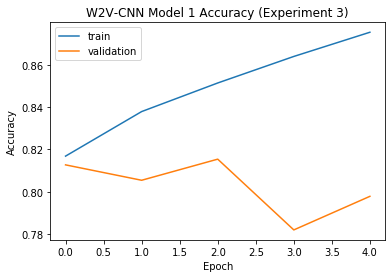

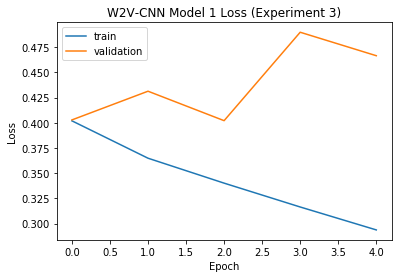

In [112]:
#Graphs

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('W2V-CNN Model 1 Accuracy (Experiment 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('W2V-CNN Model 1 Loss (Experiment 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

In [0]:
#trainable = false, batchsize = 64
def get_model2():
  model2 = Sequential()

  embedding_layer = Embedding(100000, 200, weights=[embedding_matrix], input_length=50, trainable=False)
  model2.add(embedding_layer)

  model2.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
  model2.add(GlobalMaxPooling1D())
  model2.add(Dense(256, activation='relu'))
  model2.add(Dense(1, activation='sigmoid'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model2


In [125]:
filepath="drive/My Drive/CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint2 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model_3 = get_model2()

history2 = model_3.fit(X_train, y_train, batch_size=64, epochs=6, validation_split=0.01, callbacks = [checkpoint2])

Train on 1580080 samples, validate on 15961 samples
Epoch 1/6
1580080/1580080 [==============================] - 114s 72us/step - loss: 0.4162 - acc: 0.8080 - val_loss: 0.4231 - val_acc: 0.7992

Epoch 00001: val_acc improved from -inf to 0.79920, saving model to drive/My Drive/CNN_best_weights.01-0.7992.hdf5
Epoch 2/6
1580080/1580080 [==============================] - 113s 72us/step - loss: 0.3943 - acc: 0.8207 - val_loss: 0.4126 - val_acc: 0.8060

Epoch 00002: val_acc improved from 0.79920 to 0.80603, saving model to drive/My Drive/CNN_best_weights.02-0.8060.hdf5
Epoch 3/6
1580080/1580080 [==============================] - 108s 69us/step - loss: 0.3870 - acc: 0.8248 - val_loss: 0.4454 - val_acc: 0.7770

Epoch 00003: val_acc did not improve from 0.80603
Epoch 4/6
1580080/1580080 [==============================] - 107s 68us/step - loss: 0.3824 - acc: 0.8272 - val_loss: 0.4499 - val_acc: 0.7761

Epoch 00004: val_acc did not improve from 0.80603
Epoch 5/6
1580080/1580080 [================

In [126]:
loaded_CNN_model2 = load_model('drive/My Drive/CNN_best_weights.02-0.8060.hdf5')
score2 = loaded_CNN_model2.evaluate(x=x_test_seq, y=y_test)

359/359 [==============================] - 0s 1ms/step


In [127]:
score2[0]

0.40975428656947316

In [128]:
score2[1]

0.7688022287443156

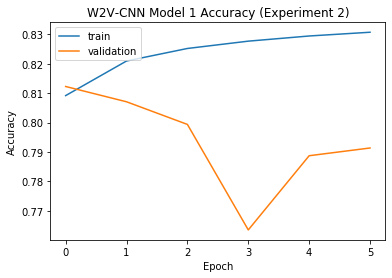

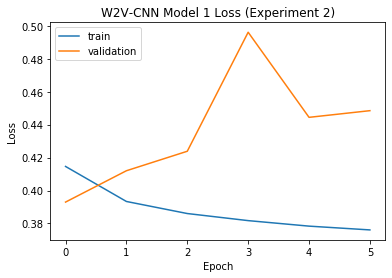

In [71]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])

plt.title('W2V-CNN Model 1 Accuracy (Experiment 2)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('W2V-CNN Model 1 Loss (Experiment 2)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

In [123]:
filepath="drive/My Drive/CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint3 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model_4 = get_model3()

history3 = model_4.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.01, callbacks = [checkpoint3])

Train on 1580080 samples, validate on 15961 samples
Epoch 1/5
  25536/1580080 [..............................] - ETA: 1:02:53 - loss: 0.4829 - acc: 0.7684

KeyboardInterrupt: ignored